In [1]:
module qt
    include("QuantumTrajectories.jl")
end

Main.qt

In [2]:
# The macro that enables a more complete matrix output.
macro show(matrix)
   :(show(stdout, "text/plain", $(matrix))) 
end

@show (macro with 1 method)

In [3]:
using LinearAlgebra
using Plots
using LaTeXStrings
using NumericalIntegration

In [4]:
# Hamiltonian parameters
t1 = 1.0
t2 = 0.5
V = 1.5

# The thermal bath parameters
temperature = 0.1
gamma = 0.5

# The measured observable bond unitary Bloch sphere angles
ϕ = π/2
θ = π/4
taum = 20.0

# The simulation paramters
dt = 0.01
T=14800
N=4

# The relevant objects are created for the bond-unitary measurements in the Rice-Mele model
# ρ0 is the initial density matrix. The flag pos=false is set so that the initial density matrix is the 
# Gibbs state at the temperature of the thermal bath.
# H, x, and J are the Rice-Mele Hamiltonian, position observable, and the current observable, respectively.
# λ matrix contains the jump operators for the thermalizing dissipator. The flag decay="T" sets the decay
# to be thermal.
ρ0, H, x, J, λ = qt.build_objects_2band_position(-t1, -t2, V, gamma, N, decay="T", temp=temperature, pos=false)

# The measured observable is defined by the Bloch sphere angles θ and ϕ.
# These specify the basis on each bond in which the system is measured.
# By specifying the unitary, the measured observable θobs is created. 
U2 = qt.unitary2R(π/2, π/2+ϕ, θ)
block = U2*[1.0+0.0im 0.0; 0.0 0.0]*U2'
θmat = zeros(ComplexF64, 2*N, 2*N)

for i in 1:2:2*N-1
    θmat[i:i+1, i:i+1] = 2*i*diagm([1.0, 1.0]).+block
end

θobs = qt.observable([θmat], (1.0, ), qt.make)

# The charge displacement operator specifies how the average position
# of the particle is changed during the instants of measurement
Q = qt.measurement_charge_displacement(θ, ϕ, N)
Qϵ = H.vectors'*Q*H.vectors
Qexp = real(tr(Qϵ*ρ0.matrix))

# The algorithm used here performs a measurement on every n-th step
n = round(Int, taum/dt)
ts, cur  = qt.ratchet_measure_int!(ρ0, dt, T*dt, n, H, θobs, J, λ, transform=false)

# The integrated current measures the full displacement of the particle
cur_int = [integrate(ts[1: i], cur[1:i]) for i in 2:length(ts)]
cur_int_tot = cur_int.+[zeros(n-1); Qexp*ones(length(ts)-n)]

14800-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 -1.7098085154677558
 -1.7099708509900118
 -1.7101245408485626
 -1.7102695682647895
 -1.710405922125789
 -1.7105335969839592
 -1.7106525930520775
 -1.7107629161938664
 -1.7108645779100622
 -1.7109575953199985
 -1.7110419911387207
 -1.7111177936496527

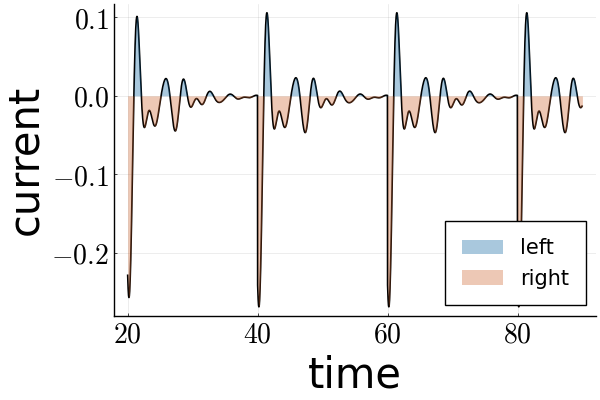

findfont: Font family ['cm'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cm'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cm'] not found. Falling back to DejaVu Sans.


In [5]:
# The time window for the plotted dynamics
start = 2000
final = 9000

# When the current is positive the particle moves to the right (blue in the figure)
# and when it is negative it moves to the left (red in the figure)
poscur = [cur[i]>=0 ? cur[i] : 0.0 for i in 1:length(cur)]
negcur = [cur[i]<=0 ? cur[i] : 0.0 for i in 1:length(cur)]

plot(ts[start:final], cur[start:final], linewidth=1.2, label=false, color="black", xlabelfontsize=30, ylabelfontsize=30,
    xtickfontsize=20, ytickfontsize=20, legend=:bottomright, legendfontsize=15, fontfamily="cm")
plot!(ts[start:final], poscur[start:final], fillrange =  zeros(Float64, length(cur[start:final])),
    linewidth=0.0, fillalpha = 0.35, c = 1, fillcolor="#09629e", label = "left")
plot!(ts[start:final], negcur[start:final], fillrange =  zeros(Float64, length(cur[start:final])),
    linewidth=0.0, fillalpha = 0.35, c = 1, fillcolor="#ce632d", label = "right")

ylabel!("current")
xlabel!("time")

In [6]:
Plots.savefig("images/dynamics_example1.png")

"/home/luka/Code/Github portfolio/QuantumRatchet/images/dynamics_example1.png"